In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.random.seed(1)

In [2]:
# (a) Loading data and computing correlations.
train = pd.read_csv('train.csv', header=None)
X_train = train.iloc[:, :-1].values
# The target y is included as the last column of train.csv.
y_train = train.iloc[:, -1].values

In [3]:
# compute the correlation of each predictor variable X[:, i] with the target variable y.
Rxy = np.corrcoef(X_train, y_train, rowvar=False)[-1, :-1]

In [4]:
# (b) Fitting the bagging model
p = 100                        # Number of trees to be used
bagging = RandomForestRegressor(n_estimators=p, bootstrap=True, max_features=1.0).fit(X_train, y_train)                  # Define and fit the model

In [5]:
# (c) Loading the test data...
test = pd.read_csv('test.csv', header=None)
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values # As above, the target is included as the last column of test.csv.

# ...and computing the correlations between the different trees in the model
def prediction_corr(model, X, y):
    predictions = np.stack([model.estimators_[i].predict(X) for i in range(p)], axis=1)
    Ryy = np.corrcoef(predictions, rowvar=False)
    S = np.array([np.delete(Ryy[i, :], i) for i in  range(p)])
    return np.mean(S)
print(prediction_corr(bagging, X_test, y_test))

0.6461962467609036


In [6]:
# (d) Computing the correlations between the residuals instead
def residual_corr(model, X, y):
    residuals = np.stack([y - model.estimators_[i].predict(X) for i in range(p)], axis=1)
    R_ry = np.corrcoef(residuals, rowvar=False)
    S = np.array([np.delete(R_ry[i, :], i) for i in  range(p)])
    return np.mean(S)
print(residual_corr(bagging, X_test, y_test))

0.5948010704602513


We see that the average prediction correlation coefficient $\approx 0.65$, and the average residuals correlation coefficient $\approx 0.59$.

 We believe that the correlations between residuals is a more appropriate metric, since it can be more directly related to the variance fitted by the model 

In [7]:
# (e) Training RFs with different numbers of subsampled features for each tree
RFs = dict()
Qs = np.linspace(0.2,1, 5) 
for q in Qs:
    RFs[q] = RandomForestRegressor(n_estimators=p, bootstrap=True, max_features=q).fit(X_train, y_train)

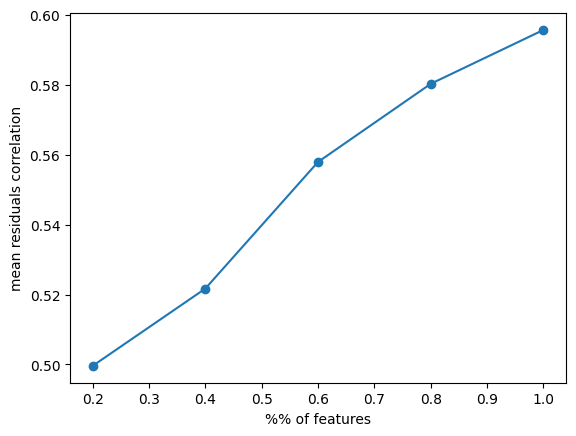

In [8]:
# (f) Residual correlations for different numbers of features
rf_res_corr = []
for q in Qs:
    rf_res_corr.append(residual_corr(RFs[q], X_test, y_test))
plt.plot(Qs, rf_res_corr, 'o-')
plt.xlabel("%% of features")
plt.ylabel("mean residuals correlation")
plt.show()

We see that the correlation increases when more features are included per tree.

Using a lower amount of randomly selected features for each tree results in higher variance in predictions, as one would expect, which is useful due to the correlation introduced by bootstrapping.

/tmp/ipykernel_4993/776780471.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


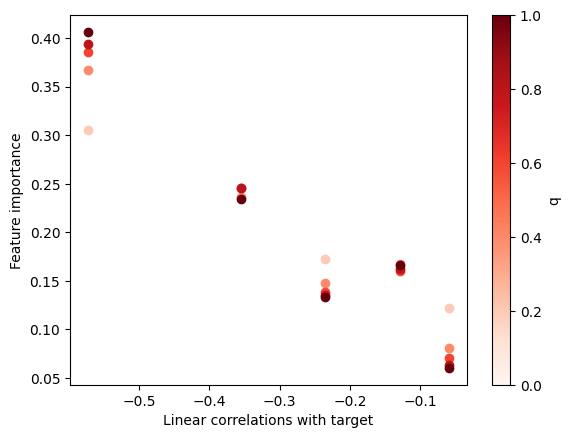

In [9]:
# (g) Computing the feature importances and plotting them against the linear correlations
cmap = cm.Reds
for q in Qs:
    color = cmap(q)
    # Fill this in
    plt.scatter(Rxy, RFs[q].feature_importances_, color=color)
    
# Stuff to make it look decent
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm)
cbar.set_label('q')
plt.xlabel('Linear correlations with target')
plt.ylabel('Feature importance')
plt.show()

We see that for the models with fewer features () per tree, there is little difference in importance across all features ($0.12 \leq \text{importance}(X_j) \leq 0.25$ when using 1 feature).

In contrast, when more features are included, the feature importance varies more greatly ($0.45 \leq \text{importance}(X_j) \leq 0.05$ when using all 5 features).

In both cases, the order of features in importance is the same as in the strength of thier correlation with the response $y$. 